In [ ]:
import cv2 as cv
import numpy as np
import glob
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
dir = "/content/drive/My Drive/Vision/Project2_vhal/Part_1/"
np.set_printoptions(suppress=True)


Part 1: Finding Corners and Calibrating
reference for code: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html
Images are stored at "/content/drive/My Drive/Vision/Project2_vhal/Part_1/, " access is permitted to the TA and the instructor

In [ ]:
def calibrate(images,gridsize,show_img=True):
  """
  Finds chessboard corners in each image in a list of images, and use the corners 
  to find the parameters of the camera

  input:
  images: list containing the locations of images
  gridsize: the number of corners that should be found, make sure this number has the right value
  show_img: whether the image before and after corners are printed on it should be displayed

  returns:
  mean_error/len(objpoints):This is the MSE of reprojection using the camera parameters
  mtx: The intrinsic camera matrix K
  dist: Distortion coefficients for the camera
  rvecs: rotation vectors for each image
  tvecs: translation vectors for each image
  """
  # termination criteria
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
  # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
  
  row,col = gridsize
  #row,col = 9,6
  objp = np.zeros((row*col,3), np.float32)
  objp[:,:2] = np.mgrid[0:row,0:col].T.reshape(-1,2)
  #print(objp)
  
  # Arrays to store object points and image points from all the images.
  objpoints = [] # 3d point in real world space, in pixel units
  imgpoints = [] # 2d points in image plane, to store the corners detected.
  
  #print(images)
  for i,fname in enumerate(images):
      img = cv.imread(fname)
      #cv2_imshow(img)
      
      gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      #plt.imshow(gray)
      #plt.show()
      
      # Find the chess board corners
      ret, corners = cv.findChessboardCorners(gray, (row,col), None)
      
      print("Operation on image ",i, " is: ",ret)
      # If found, add object points, image points (after refining them)
      if ret == True:
          
          objpoints.append(objp)
          
          #refine the corners
          corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
          
          imgpoints.append(corners)
          
          if show_img==True:
            # Draw and display the corners
            cv.drawChessboardCorners(img, (row,col), corners2, ret)
            plt.imshow(img)
            plt.show()

  #calibrate the camera using the corners
  ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

  mean_error = 0
  for i in range(len(objpoints)):
      imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
      error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
      mean_error += error
  #we square the mean error to get the mean squared error
  return (mean_error/len(objpoints))**2, mtx, dist, rvecs, tvecs

Operation on image  0  is:  True


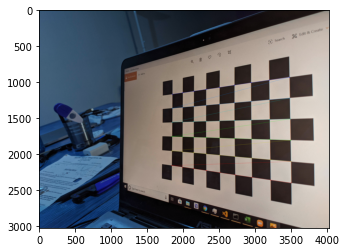

Operation on image  1  is:  True


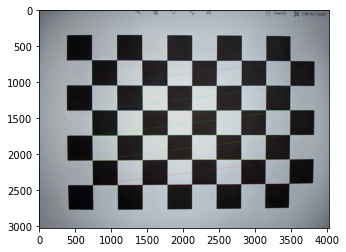

Operation on image  2  is:  True


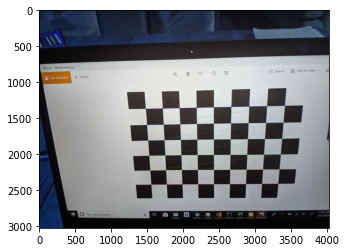

Operation on image  3  is:  True


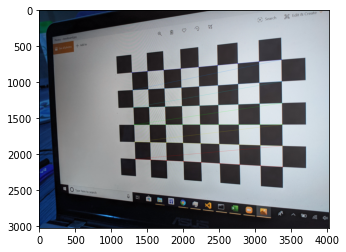

Operation on image  4  is:  True


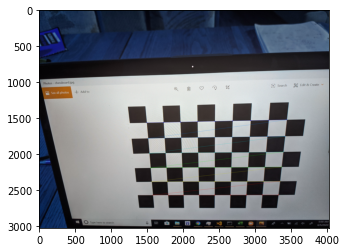

Operation on image  5  is:  True


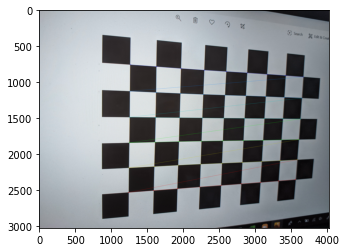

Operation on image  6  is:  True


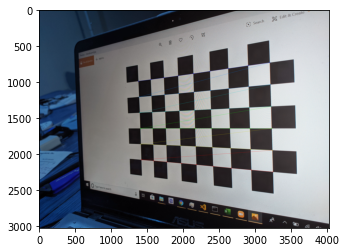

Operation on image  7  is:  True


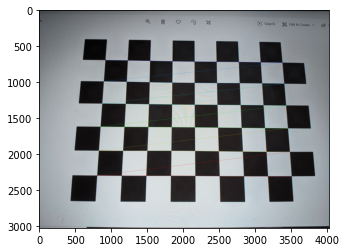

Operation on image  8  is:  True


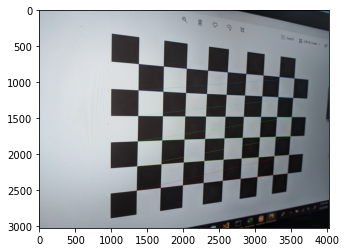

Operation on image  9  is:  True


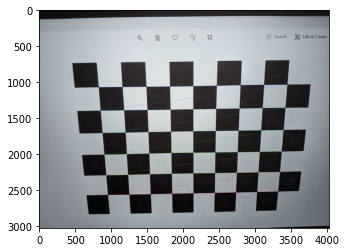

In [ ]:
#find and print the corners
images = glob.glob(dir+'IMG_*.jpg')
gridsize = (9,6)
MSE, mtx, dist, rvecs, tvecs = calibrate(images,gridsize)

In [ ]:
#rough work
print(len(rvecs),tvecs[1].shape)

10 (3, 1)


In [ ]:
#K is
print("K is")
print(mtx)

print("distortion coefficients are")
print(dist)

#Reprojection mse
print( "Total reprojection error (mean squared error) is error: {}".format(MSE) )

K is
[[3240.60433542    0.         2028.73169396]
 [   0.         3244.3704965  1504.56690725]
 [   0.            0.            1.        ]]
distortion coefficients are
[[ 0.23966791 -1.35215859  0.00088688  0.00055514  2.19938318]]
Total reprojection error (mean squared error) is error: 0.049780902547380025


<h3>Part 2:</h3> Take an image and undistort it

The original image


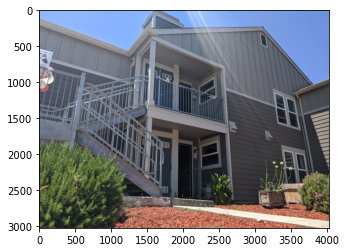

Showing undistorted image


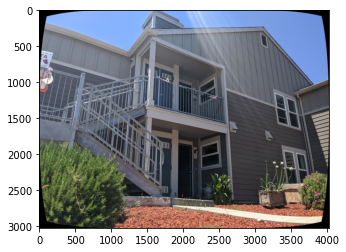

The undistorted image cropped


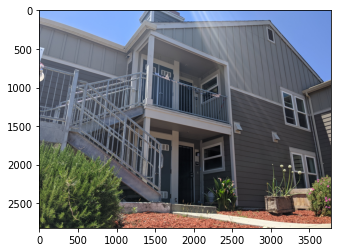

In [ ]:
dir3 = dir.replace('Part_1/', 'Part_3/')

#original image
img2 = cv.imread(dir3+'MrHouse.jpg')
h,  w = img2.shape[:2]

#get a better intrinsic matrix
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

print("The original image")
RGB_img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
plt.imshow(RGB_img2)
plt.show()

# undistort
dst = cv.undistort(img2, mtx, dist, None, newcameramtx)

print("Showing undistorted image")
RGB_dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
cv.imwrite(dir3+'undistorted_house_uncropped.png', dst)
plt.imshow(RGB_dst)
plt.show()
plt.close()

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
RGB_dst = RGB_dst[y:y+h, x:x+w]
cv.imwrite(dir3+'undistorted_drhouse.png', dst)
print("The undistorted image cropped")
plt.imshow(RGB_dst)
plt.show()
plt.close()

Part 3:
Draw the lines.
Used OpenCV to draw the lines but did not do it on Colab since Colab doesn't have interactive windows.

Here is the image with the lines drawn


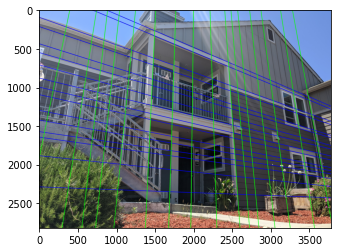

In [ ]:
print("Here is the image with the lines drawn")
img_3 = cv.imread(dir3+"lines_drawn.jpg")
#cv2_imshow(img_3)
plt.imshow(cv.cvtColor(img_3,cv.COLOR_BGR2RGB))

Part 3 (there are two part three's): Get the levers and then the normals to the vertical, horizontal and transversal planes

In [ ]:
def get_lever_norm(x_sensor_i1,x_sensor_i2,K):
  """
  return the (1,3) unit norm lever vector for sensor points x_sensor_i1,x_sensor_i2,K

  input:
  x_sensor_i1: the x,y sensor coordinates of the first point forming the line
  x_sensor_i2: the x,y sensor coordinates of the second point forming the line
  K: the intrinsic camera matrix

  returns: 
  lever: the unit norm lever vector, formed by the cross product between the augmented coord of the 2 sensor points 
  """
  M = np.linalg.inv(K)
  #print(M.shape)
  xi1 = np.array([[x_sensor_i1[0]], [x_sensor_i1[1]], [1]])
  xi2 = np.array([[x_sensor_i2[0]], [x_sensor_i2[1]], [1]])
  assert xi1.shape==xi2.shape
  assert xi1.shape==(3,1)
  lever = np.cross(np.dot(M,xi1).T,np.dot(M,xi2).T)
  l_norm = np.sqrt(lever[0,0]**2 + lever[0,1]**2 + lever[0,2]**2)
  lever = lever/l_norm if not l_norm==0 else lever
  return lever

def LMedS(N,lines,K):
  """
  Calculates the plane for a bundle of lines using the Least Median of Squares method

  input
  N: number of iterations for LMedS
  lines: a numpy array where each element is a 2,2 array containing the x,y coord 
        for the points forming the line at that index
  K: the intrinsic camera matrix

  returns
  val: the minimum median residual value
  plane: The plane which is supposed to pass through all of these lines
  """
  medians = []
  indices = []
  for i in range(N):

    #get 2 random lines from the bundle
    idx1,idx2 = random.sample([x for x in range(len(lines))], k=2) #np.random.randint(len(lines),size=2)
    line_1,line_2 = lines[idx1,:,:],lines[idx2,:,:]

    #calculate their unit norm lever vectors
    lever_1 = get_lever_norm(line_1[0,:],line_1[1,:],K)
    lever_2 = get_lever_norm(line_2[0,:],line_2[1,:],K)

    #calculate the normal to the plane formed by these two lever vectors
    m = np.cross(lever_1,lever_2)
    m_norm = np.sqrt(m[0,0]**2 + m[0,1]**2 + m[0,2]**2)
    m = m/m_norm if m_norm!=0 else m
    
    #Calculate the residual between the lever vector of every other line in the bundle and this plane,
    #ideally the residual for each point should be 0
    r = []
    temp_indices = []
    for index,line in enumerate(lines):
      if index!=idx1 and index!=idx2:
        lever_k = get_lever_norm(line[0,:],line[1,:],K)

        #compute residual
        residual = abs(np.dot(lever_k,m.T)[0])
        r.append([residual,m[0,0],m[0,1],m[0,2]])
        #print(index)
    
    #print(r[0])
    r = np.array(r)
    #print(r.shape)
    
    #calculate the median of these residuals and keep track of the medians obtained for every 2 pairs
    median = sorted(r, key=lambda x:x[0])[(r.shape[0]+1)//2]
    medians.append(median)
  
  #print(len(medians))
  val_tuple = min(medians,key=lambda x:x[0])
  val,plane = val_tuple[0],val_tuple[1:]

  return val,np.array([x for x in plane])
  #return val,val_arg

In [ ]:
#Define the points for the lines, obtained using OpenCV on my machine while drawing the lines
points = np.array([[[2488, 1048],
  [3138, 1266]],

 [[2494, 1217],
  [3164, 1427]],

 [[2503, 1399],
  [3221, 1597]],

 [[2539, 1661],
  [3224, 1814]],

 [[2536, 1794],
  [3215, 1927]],

 [[2553, 2004],
  [3268, 2105]],

 [[2565, 2153],
  [2984, 2197]],

 [[2586, 2383],
  [2908, 2395]],

 [[1452,  314],
  [2423,  717]],

 [[2480,  975],
  [3138, 1209]],

 [[2542, 1863],
  [3265, 1988]],

 [[2547, 1939],
  [2999, 2004]],

 [[1390, 1217],
  [2491, 1484]],

 [[1488,  262],
  [2450,  673]],

 [[ 186,  604],
  [ 921,  818]],

 [[2527, 1592],
  [3232, 1758]],

 [[2506,  217],
  [2571,  975]],

 [[2595,  209],
  [2674, 1016]],

 [[1998,  229],
  [1995,  467]],

 [[2223,  221],
  [2234,  568]],

 [[2754,  209],
  [2854, 1064]],

 [[2902,  193],
  [3026, 1113]],

 [[3197,  427],
  [3286,  996]],

 [[1496,  334],
  [1461, 1072]],

 [[ 679,  419],
  [ 631 , 721]],

 [[ 333,  314],
  [ 271,  613]],

 [[3407,  661],
  [3469,  996]],

 [[ 797,  770],
  [ 832,  475]],

 [[ 956,  798],
  [ 986,  528]],

 [[1059, 1919],
  [1113, 1379]],

 [[1730, 1266],
  [1750,  657]],

 [[2550, 2036],
  [2456,  697]]])

#Each line contains 2 points, and there are 30 lines 
print("shape of the array points: ", points.shape)

#split this array into 2 bundles: one for horizontal and the other for vertical
points_horizontal = points[:16,:,:]
points_vertical = points[16:,:,:]

shape of the array points:  (32, 2, 2)


In [ ]:
#Calculate the vertical plane mcv and horizontal plane mch
#commented because we negated mcv and mch based on the values we got and running it again would change the values. Feel free to uncomment it
#res_v,mcv = LMedS(500,points_vertical,mtx)
#res_h,mch = LMedS(500,points_horizontal,mtx)


In [ ]:
#sameasabove
#mcv,mch = -mcv.reshape((1,3)), -mch.reshape((1,3))

In [ ]:

#As the professor said in his announcement, we negate the mcv and mch values based on if the image is 
#horizontally or vertically rotated
print("Vertical plane is: ",mcv)
print("Horizontal plane is: ",mch,"\n")

print("Vertical residual is: ",res_v)
print("Horizontal residual is: ",res_h,"\n")

#Calculate the transversal plane mct
#changed from v x h
mct = np.cross(mch.reshape((1,3)),mcv.reshape((1,3)))
mct = mct/np.linalg.norm(mct)

print("Transversal plane is: ",mct,"\n")

angle = np.arccos(np.dot(mcv,mch.T))
print("The angle between mcv and mch is ", np.degrees(angle), " degrees\n")


Vertical plane is:  [[ 0.01407251  0.93772932 -0.34708167]]
Horizontal plane is:  [[0.82236944 0.18296865 0.5387309 ]] 

Vertical residual is:  [0.00460766]
Horizontal residual is:  [0.00502419] 

Transversal plane is:  [[-0.56869301  0.29301281  0.76859076]] 

The angle between mcv and mch is  [[90.21977284]]  degrees



In [ ]:
#calculate the vanishing points using v = K*line
v_h,v_v,v_t = np.dot(mtx,mch.reshape((3,1))), np.dot(mtx,mcv.reshape((3,1))), np.dot(mtx,mct.reshape((3,1)))
v_h = v_h/v_h[-1] if v_h[-1]!=0 else v_h
v_v = v_v/v_v[-1] if v_v[-1]!=0 else v_v
v_t = v_t/v_t[-1] if v_t[-1]!=0 else v_t

print("Horizontal vanishing point:\n ",v_h)
print("Vertical vanishing point: \n",v_v)
print("Transversal vanishing point: \n",v_t)

Horizontal vanishing point:
  [[6975.49451514]
 [2606.44931988]
 [   1.        ]]
Vertical vanishing point: 
 [[ 1897.34064056]
 [-7260.92427975]
 [    1.        ]]
Transversal vanishing point: 
 [[-369.04501167]
 [2741.43074071]
 [   1.        ]]


Part 4: the homography 

In [ ]:
#W = [mch,mcv,mct].T
weights = np.concatenate([mch.T,mcv.T,mct.T], axis=1)
print("Weights\n")
print(weights)

#H = K W^-1 K^-1
H = mtx@ np.linalg.inv(weights)@ np.linalg.inv(mtx)
print("H\n")
print(H)

Weights

[[ 0.82236944  0.01407251 -0.56869301]
 [ 0.18296865  0.93772932  0.29301281]
 [ 0.5387309  -0.34708167  0.76859076]]
H

[[    0.4664138      0.36957505  1798.51061187]
 [   -0.24678896     1.07432874 -1078.7083857 ]
 [   -0.00017549     0.00009031     0.98872868]]


In [ ]:
#calculating the translation and the bounding box size

#get the image
inp_img = cv.imread(dir3+'lines_drawn.jpg')

#map the points (0,0), (0,size_y), (size_x,0), (size_x,size_y) using the homography to calculate the
#new corners
c1 = H@np.array([[0,0,1]]).T
c2 = H@np.array([[inp_img.shape[0],0,1]]).T
c3 = H@np.array([[0,inp_img.shape[1],1]]).T
c4 = H@np.array([[inp_img.shape[0],inp_img.shape[1],1]]).T

#unaugment the coordinates
c1 = c1/c1[2]
c2 = c2/c2[2]
c3 = c3/c3[2]
c4 = c4/c4[2]

In [ ]:
print("The corners after homography are:\n")
print("c1\n ",c1)
print("c2\n ",c2)
print("c3\n ",c3)
print("c4\n ",c4)

The corners after homography are:

c1
  [[ 1819.0132844 ]
 [-1091.00545231]
 [    1.        ]]
c2
  [[ 6301.99706816]
 [-3591.7491417 ]
 [    1.        ]]
c3
  [[2402.99790218]
 [2245.3762958 ]
 [   1.        ]]
c4
  [[5398.22500871]
 [2741.99216704]
 [   1.        ]]


In [ ]:
min_x = min (c1[0,0],c2[0,0],c3[0,0],c4[0,0])
min_y = min (c1[1,0],c2[1,0],c3[1,0],c4[1,0])
max_x = max(c1[0,0],c2[0,0],c3[0,0],c4[0,0])
max_y = max(c1[1,0],c2[1,0],c3[1,0],c4[1,0])

bb = ((min_x,min_y), (max_x,max_y))
#print(bb[0])

#we need to map the point c1 to 0,0 because we want the new image to start at 0,0 in the bounding box
#translate the entire image by -c1x, -c1y
trans = np.array([[1,0,float(-bb[0][0])],
                  [0,1,float(-bb[0][1])],
                  [0,0,1]])
trans

array([[    1.       ,     0.       , -1819.0132844],
       [    0.       ,     1.       ,  3591.7491417],
       [    0.       ,     0.       ,     1.       ]])

In [ ]:
temp_c1, temp_c2, temp_c3, temp_c4 = trans@c1, trans@c2, trans@c3, trans@c4

In [ ]:
#temp_c4

In [ ]:
#Apply the homography (translation*H) to the input image using warpPerspective
transformation = np.dot(trans,H)
size_x = int(max(c1[0,0],c2[0,0],c3[0,0],c4[0,0]) - min (c1[0,0],c2[0,0],c3[0,0],c4[0,0]))
size_y = int(max(c1[1,0],c2[1,0],c3[1,0],c4[1,0]) - min (c1[1,0],c2[1,0],c3[1,0],c4[1,0]))
#should define the bottom right corner for the bounding box, be able to accomodate all the points
out_img = cv.warpPerspective(inp_img,trans@H,(size_x,size_y))

True

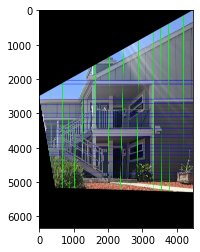

In [ ]:
RGB_out = cv.cvtColor(out_img, cv.COLOR_BGR2RGB)
plt.imshow(RGB_out)
cv.imwrite(dir3+"perspective_corrected.png",out_img)
#plt.show()


In [ ]:
print("The dimension of the new rectangular frame is: ",out_img.shape)

print("the homography matrix is\n")
print(H/H[-1,-1])

print("The vanishing points after applying the homography, calculated using H*v_old are\n")
print("v_h_new\n: ",H@v_h)
print("v_v_new\n: ",H@v_v)
print("v_t_new: ",H@v_t)

print("The vanishing points of both mch and mcv are now at infinity,\nshowing that the vertical and horizontal axes of the image \nare parallel to the vertical and horizontal axes of the focal plane")

The dimension of the new rectangular frame is:  (6333, 4482, 3)
the homography matrix is

[[    0.47173083     0.37378814  1819.0132844 ]
 [   -0.24960231     1.08657588 -1091.00545231]
 [   -0.00017749     0.00009134     1.        ]]
The vanishing points after applying the homography, calculated using H*v_old are

v_h_new
:  [[6015.25614789]
 [  -0.        ]
 [  -0.        ]]
v_v_new
:  [[    0.        ]
 [-9347.57077679]
 [    0.        ]]
v_t_new:  [[2639.54733427]
 [1957.56569541]
 [   1.30108251]]
The vanishing points of both mch and mcv are now at infinity,
showing that the vertical and horizontal axes of the image 
are parallel to the vertical and horizontal axes of the focal plane
